In [18]:
!pip install einops
# !pip install vit_pytorch
!pip install ipywidgets
!pip install dill
!pip install torchmeta
!git clone https://github.com/lucidrains/vit-pytorch


fatal: destination path 'vit-pytorch' already exists and is not an empty directory.


In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import dill
import math
from itertools import cycle

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchmeta.datasets.helpers import miniimagenet
from torchmeta.utils.data import NonEpisodicWrapper

from jumping_quadrupeds.eth.dataset import Hdf5ImgDataset
from jumping_quadrupeds.utils import common_img_transforms, abs_path
from torch.utils.data import RandomSampler, DataLoader, Subset

from einops import rearrange, repeat, reduce
from einops.layers.torch import Rearrange


In [2]:
torch.cuda.is_available()

True

In [3]:
# helpers
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

def exists(val):
    return val is not None

def prob_mask_like(t, prob):
    batch, seq_length, _ = t.shape
    return torch.zeros((batch, seq_length)).float().uniform_(0, 1) < prob

def get_mask_subset_with_prob(patched_input, prob):
    batch, seq_len, _, device = *patched_input.shape, patched_input.device
    max_masked = math.ceil(prob * seq_len)

    rand = torch.rand((batch, seq_len), device=device)
    _, sampled_indices = rand.topk(max_masked, dim=-1)

    new_mask = torch.zeros((batch, seq_len), device=device)
    new_mask.scatter_(1, sampled_indices, 1)
    return new_mask.bool()


def visualize(pred_pixel_values, patches, sample_id=0):
    masked_patch_pred = pred_pixel_values[sample_id].detach().cpu()
    masked_patch_true = patches[sample_id].cpu()

    pred_patches = rearrange(masked_patch_pred, 'p (h w c) -> p c h w', c=3, h=12)
    gt_patches = rearrange(masked_patch_true, 'p (h w c) -> p c h w', c=3, h=12)

    pred_recons = gt_patches.clone()
    pred_w_mask = gt_patches.clone()
    pred_recons[masked_indices[sample_id]] = pred_patches
    pred_w_mask[masked_indices[sample_id]] = 0.

    imshow(torchvision.utils.make_grid(images[sample_id].cpu()))
    imshow(torchvision.utils.make_grid(pred_recons, nrow=7))
    imshow(torchvision.utils.make_grid(pred_w_mask, nrow=7))
    imshow(torchvision.utils.make_grid(gt_patches, nrow=7))


In [4]:
# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)


In [5]:

class MAE(nn.Module):
    def __init__(
        self,
        *,
        encoder,
        decoder_dim,
        masking_ratio = 0.75,
        decoder_depth = 1,
        decoder_heads = 8,
        decoder_dim_head = 64
    ):
        super().__init__()
        assert masking_ratio > 0 and masking_ratio < 1, 'masking ratio must be kept between 0 and 1'
        self.masking_ratio = masking_ratio

        # extract some hyperparameters and functions from encoder (vision transformer to be trained)

        self.encoder = encoder
        num_patches, encoder_dim = encoder.pos_embedding.shape[-2:]
        self.to_patch, self.patch_to_emb = encoder.to_patch_embedding[:2]
        pixel_values_per_patch = self.patch_to_emb.weight.shape[-1]
        # decoder parameters

        self.enc_to_dec = nn.Linear(encoder_dim, decoder_dim) if encoder_dim != decoder_dim else nn.Identity()
        self.mask_token = nn.Parameter(torch.randn(decoder_dim))
        self.decoder = Transformer(dim = decoder_dim, depth = decoder_depth, heads = decoder_heads, dim_head = decoder_dim_head, mlp_dim = decoder_dim * 4)
        self.decoder_pos_emb = nn.Embedding(num_patches, decoder_dim)
        self.to_pixels = nn.Linear(decoder_dim, pixel_values_per_patch)

    def forward(self, img):
        device = img.device

        # get patches
        patches = self.to_patch(img)
        batch, num_patches, *_ = patches.shape

        # patch to encoder tokens and add positions
        tokens = self.patch_to_emb(patches)
        tokens = tokens + self.encoder.pos_embedding[:, 1:(num_patches + 1)]

        # calculate of patches needed to be masked, and get random indices, dividing it up for mask vs unmasked
        num_masked = int(self.masking_ratio * num_patches)
        rand_indices = torch.rand(batch, num_patches, device = device).argsort(dim = -1)
        masked_indices, unmasked_indices = rand_indices[:, :num_masked], rand_indices[:, num_masked:]

        # get the unmasked tokens to be encoded
        batch_range = torch.arange(batch, device = device)[:, None]
        tokens = tokens[batch_range, unmasked_indices]

        # get the patches to be masked for the final reconstruction loss
        masked_patches = patches[batch_range, masked_indices]

        # attend with vision transformer
        encoded_tokens = self.encoder.transformer(tokens)

        # project encoder to decoder dimensions, if they are not equal - the paper says you can get away with a smaller dimension for decoder
        decoder_tokens = self.enc_to_dec(encoded_tokens)

        # reapply decoder position embedding to unmasked tokens
        decoder_tokens = decoder_tokens + self.decoder_pos_emb(unmasked_indices)

        # repeat mask tokens for number of masked, and add the positions using the masked indices derived above
        mask_tokens = repeat(self.mask_token, 'd -> b n d', b = batch, n = num_masked)
        mask_tokens = mask_tokens + self.decoder_pos_emb(masked_indices)

        # concat the masked tokens to the decoder tokens and attend with decoder
        decoder_tokens = torch.cat((mask_tokens, decoder_tokens), dim = 1)
        decoded_tokens = self.decoder(decoder_tokens)

        # splice out the mask tokens and project to pixel values
        mask_tokens = decoded_tokens[:, :num_masked]
        pred_pixel_values = self.to_pixels(mask_tokens)

        # calculate reconstruction loss
        recon_loss = F.mse_loss(pred_pixel_values, masked_patches)
        return recon_loss, pred_pixel_values, masked_indices, unmasked_indices, patches


In [6]:
IMAGE_SIZE = 84
PATCH_SIZE = 12 # 32
NUM_PATCHES = 84//12
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

vit = ViT(
    image_size=IMAGE_SIZE, #256
    patch_size=PATCH_SIZE,
    num_classes=1000,
    dim=1024,
    depth=2,
    heads=8,
    mlp_dim=512, #2048
    # dropout=0.1,
    # emb_dropout=0.1
).to(device)
mae = MAE(
    encoder = vit,
    masking_ratio = 0.75,   # the paper recommended 75% masked patches
    decoder_dim = 128,      # paper showed good results with just 512
    decoder_depth = 1       # anywhere from 1 to 8
).to(device)

opt = torch.optim.Adam(mae.parameters(), lr=1e-3)


In [7]:

transform = common_img_transforms(size=IMAGE_SIZE)

ds_path = "../random-rollouts-50k/CarRacing-v0_rollouts_e256_t200.hdf5"
train_dataset = Hdf5ImgDataset(ds_path, transform=transform, flat=True)
sampler = RandomSampler(train_dataset)
dataloader = DataLoader(train_dataset, batch_size=128)
dataloader = iter(dataloader)

In [15]:
next(dataloader)

StopIteration: 

In [62]:
NUM_EPOCHS = 2
for epoch in range(NUM_EPOCHS):
    for step, images in enumerate(dataloader):
        images = images.to(device)
        print(step)
        if step % 10 == 0:
            print(f"step: {step}, loss: {loss.item()}")
        loss, pred_pixel_values, masked_indices, unmasked_indices, patches = mae(images)
        loss.backward()
        opt.zero_grad()
        opt.step()



0
step: 0, loss: 0.0054573542438447475


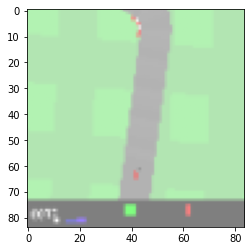

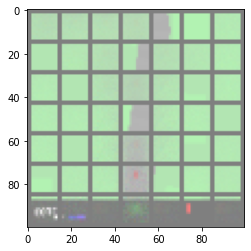

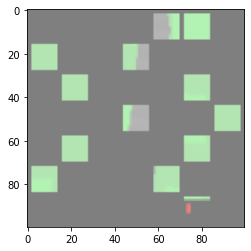

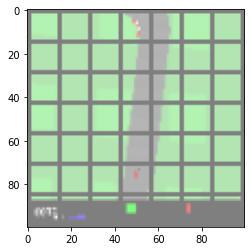

In [15]:
visualize(pred_pixel_values, patches)

In [13]:
imgs = x[0]
for i in range(imgs.shape[0]):
    plt.show(imgs[i].T)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [17]:
dataset = miniimagenet('data', ways=5, shots=5, meta_train=True, download=True)
dataset = NonEpisodicWrapper(dataset)
dataloader = iter(cycle(DataLoader(dataset, batch_size=128, shuffle=True)))


In [37]:
NUM_EPOCHS = 2

for epoch in range(NUM_EPOCHS):
    for step, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        loss, pred_pixel_values, masked_indices, unmasked_indices, patches = mae(images)
        opt.zero_grad()
        if step % 100 == 0:
            print(f"step: {step}, loss: {loss.item()}")
        loss.backward()
        opt.step()



ValueError: too many values to unpack (expected 2)